<h3>Part One: Create a Classifier</h3>

In [1]:
import pandas as pd
import numpy as np
import datetime

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes
from sklearn.metrics import accuracy_score

In [2]:
# Read in the .csv generated in Part One

df = pd.read_csv('china_articles_cleaned.csv')
df['joined'] = df['lemmas'].apply(lambda x: ' '.join(eval(x)))
df.drop(columns=['Unnamed: 0'], inplace=True)

df.head()

,title,source,content,source_num,regexed,tokens,word_count,title_len,lemmas,joined
0,China urges greater efforts to ease Korean ten...,Global Times (China),China hopes all parties would do more to ease ...,0,china hopes all parties would do more to ease ...,"['china', 'hopes', 'parties', 'would', 'ease',...",276,51,"['china', 'hope', 'party', 'would', 'ease', 't...",china hope party would ease tension korean pen...
1,Multilateral cooperation involving China best ...,Global Times (China),The US and several Western powers including Au...,0,the us and several western powers including au...,"['us', 'several', 'western', 'powers', 'includ...",273,79,"['u', 'several', 'western', 'power', 'includin...",u several western power including australia su...
2,"Despite pandemic at home, US continues to make...",Global Times (China),Illustration: Liu Rui/GT\n\n\n\nOver the last ...,0,illustration liu rui gt over the last two ...,"['illustration', 'liu', 'rui', 'gt', 'last', '...",377,67,"['illustration', 'liu', 'rui', 'gt', 'last', '...",illustration liu rui gt last two week u govern...
3,Cut Chinese firms in eye of the storm a break:...,Global Times (China),"Photo: IC\n\n\n\n\nAccording to Reuters, Chine...",0,photo ic according to reuters chinese le...,"['photo', 'ic', 'according', 'reuters', 'chine...",438,69,"['photo', 'ic', 'according', 'reuters', 'chine...",photo ic according reuters chinese leading chi...
4,Finnair launches new flight services for China,Global Times (China),"Lars Olofsson, Greater China sales director at...",0,lars olofsson greater china sales director at...,"['lars', 'olofsson', 'greater', 'china', 'sale...",361,46,"['lars', 'olofsson', 'greater', 'china', 'sale...",lars olofsson greater china sale director finn...


Explanatory note. In our first trial of this process, we started with five sources. However, for the sake of simplicity we eventually decided to focus on only three: Epoch Times, Global Times, and New York Times. The data from Lexis Nexis and the above .csv had already been created using a list of five sources instead of three, so because of the randomness of the sampling process, we cannot re-run the SQL query and perfectly re-create the .csv file (sans content from the two excluded sources). For the remainder of this notebook, I will be working from the .csv, but the next code block first drops the two unwanted sources and rewrites our `source_to_source_num` and `source_num_to_source` dictionaries to include only three sources.

In [3]:
# Drop unwanted sources, simply the "source" field, and rewrite dictionaries

df = df[df['source_num'] != 3]
df = df[df['source_num'] != 4]

source_num_to_source = {0: 'Global Times', 
                        1: 'Epoch Times', 
                        2: 'New York Times'}
source_to_source_num = {'Global Times': 0,
                        'Epoch Times': 1,
                        'New York Times': 2}

df['source'] = [source_num_to_source[i] for i in df.source_num.tolist()]

print(len(df))

df.value_counts('source')

9000


source
New York Times    3000
Global Times      3000
Epoch Times       3000
dtype: int64

In [4]:
# Create training and testing data, vectorize text, and transform training data into vectors
# Note that results of the naive Bayes classifier will vary slightly due to randomness in data sampling

X = df.joined.tolist()
Y = df.source.tolist()

train_x, test_x, train_y, test_y = model_selection.train_test_split(X, Y, test_size=0.05)

print(datetime.datetime.now())
vectorizer = TfidfVectorizer(ngram_range=(1,3))
vectorizer.fit(X)
print(datetime.datetime.now())

transformed_train_x = vectorizer.transform(train_x)
transformed_test_x = vectorizer.transform(test_x)
print(datetime.datetime.now())


2021-04-26 14:19:03.515160
2021-04-26 14:19:27.987634
2021-04-26 14:19:39.074600


In [5]:
# Train naive Bayes classifier

naive = naive_bayes.MultinomialNB()
naive.fit(transformed_train_x, train_y)
predictions = naive.predict(transformed_test_x)
accuracy = accuracy_score(predictions, test_y)*100
print("Naive Bayes Accuracy On Base Articles -> ", accuracy)

Naive Bayes Accuracy On Base Articles ->  94.22222222222221


In [6]:
# This code block creates a confusion matrix from the above results

cm = np.zeros((3, 3))

for i in range(len(predictions)):
    col = source_to_source_num[predictions[i]]
    row = source_to_source_num[test_y[i]]
    cm[row][col] += 1

print(cm)

# Also print the confusion matrix normalized by row

cm = cm/cm.sum(axis=1, keepdims=True)
cm = np.round(cm, 2)
print(cm)

[[134.   7.   8.]
 [  2. 157.   5.]
 [  1.   3. 133.]]
[[0.9  0.05 0.05]
 [0.01 0.96 0.03]
 [0.01 0.02 0.97]]


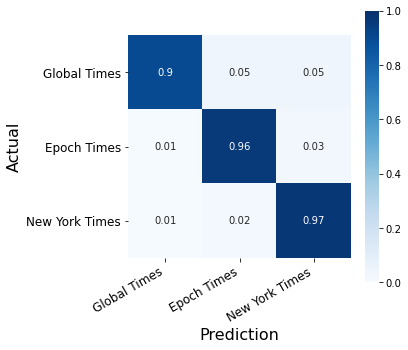

In [7]:
# This block plots the above confusion matrix

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(cm, annot=True, ax=ax, square=True,
            cmap=plt.cm.Blues, vmin=0, vmax=1,
            xticklabels=[source_num_to_source[num] for num in range(3)],
            yticklabels=[source_num_to_source[num] for num in range(3)]) 

ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, fontsize=12, ha='right')

ax.set_xlabel('Prediction', fontdict={'fontsize': 16})
ax.set_ylabel('Actual', fontdict={'fontsize': 16})

plt.show()

<h3>Part Two: Test Classifier on GPT-3 Outputs</h3>

In [8]:
# Read in dataframe containing outputs for GPT-3, GPT-2, and each of five finetuned versions of GPT-2

outputs = pd.read_csv('outputs_with_gpt2.csv')

outputs.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)

outputs.head()

,title,gpt3,untuned_gpt2,ft_source_0,ft_source_1,ft_source_2,ft_source_3,ft_source_4
0,"Indian hawks, biased media, right-wing politic...",The Indian government should immediately withd...,15th anniversary of Mao Zedong? Xi Jinping wan...,"Photo: VCGWhile the talks are going smoothly, ...",The Chinese regime ’s persecution of Falun Gon...,BEIJING -- The spiritual leader of China's spi...,KOLKATA: The chairman of Karnataka Railways (K...,While the US and its allies have begun their f...
1,Japanese firm's questions over Beijing court j...,"Besides the forced labor case, the Japanese fi...",China's Ministry of Labour said on Monday it w...,"Photo: VCGEmployees at a factory in Shenyang, ...",The Japanese government ’s Department of Justi...,BEIJING -- The Chinese authorities have punish...,BEIJING: The Chinese government is attacking a...,The ruling of the Permanent Court of Arbitrati...
2,Djibouti free trade zone demonstrates true val...,The second phase of the China-proposed Belt an...,China-supported Trade Partnership with Taiwan?...,"Photo: VCGChina-proposed B&R initiative, the C...",The World Trade Organization (WTO) announced a...,BEIJING -- The Chinese authorities have announ...,KOLKATA: The chairman of the five-member CUP (...,The latest US-China free-trade initiative had ...
3,DPP victory would endanger cooperation to prot...,China is likely to claim victory in the Spratl...,China's Global Trade Policy Transparency Repor...,While the US and its allies have begun their e...,The Chinese regime ’s persecution of freedom o...,BEIJING -- The Chinese authorities have punish...,BEIJING: The Chinese delegation convened at a ...,The ruling Workers' Party (PPP) had accused th...
4,China to require deletion of personal data 60 ...,China’s Ministry of Health has announced plans...,Labour's shadow health secretary said Britain ...,A station that processed data for Aadhaar driv...,"The Chinese regime is launching its ""Made in C...",HONG KONG -- The chairman of China's national ...,AHMEDABAD: The Department of Revenue had issue...,The World Health Organisation has said it is w...


In [9]:
# Merge GPT-3 outputs with full df and then pare down to the relevant articles

outputs = outputs.merge(df, how='outer', on='title')
print(len(outputs)) # Should result in 9000 articles + 50 GPT-3 outputs for the 2 sources that have since been dropped

outputs.dropna(subset=['gpt3'], inplace=True)
print(len(outputs)) # Should result in 125 — 25 from each of the five original sources

outputs.dropna(subset=['source'], inplace=True)
print(len(outputs)) # Should exclude the 50 GPT-3 outputs that no longer match a source from the full df

outputs.head()

9050
125
75


,title,gpt3,untuned_gpt2,ft_source_0,ft_source_1,ft_source_2,ft_source_3,ft_source_4,source,content,source_num,regexed,tokens,word_count,title_len,lemmas,joined
0,"Indian hawks, biased media, right-wing politic...",The Indian government should immediately withd...,15th anniversary of Mao Zedong? Xi Jinping wan...,"Photo: VCGWhile the talks are going smoothly, ...",The Chinese regime ’s persecution of Falun Gon...,BEIJING -- The spiritual leader of China's spi...,KOLKATA: The chairman of Karnataka Railways (K...,While the US and its allies have begun their f...,Global Times,Photo: Xinhua\n\n\n\n\nThe clash between China...,0.0,photo xinhua the clash between china and ...,"['photo', 'xinhua', 'clash', 'china', 'india',...",415.0,100.0,"['photo', 'xinhua', 'clash', 'china', 'india',...",photo xinhua clash china india galwan valley b...
1,Japanese firm's questions over Beijing court j...,"Besides the forced labor case, the Japanese fi...",China's Ministry of Labour said on Monday it w...,"Photo: VCGEmployees at a factory in Shenyang, ...",The Japanese government ’s Department of Justi...,BEIJING -- The Chinese authorities have punish...,BEIJING: The Chinese government is attacking a...,The ruling of the Permanent Court of Arbitrati...,Global Times,Chinese lawyers on Tuesday slammed a Japanese ...,0.0,chinese lawyers on tuesday slammed a japanese ...,"['chinese', 'lawyers', 'tuesday', 'slammed', '...",198.0,81.0,"['chinese', 'lawyer', 'tuesday', 'slammed', 'j...",chinese lawyer tuesday slammed japanese compan...
2,Djibouti free trade zone demonstrates true val...,The second phase of the China-proposed Belt an...,China-supported Trade Partnership with Taiwan?...,"Photo: VCGChina-proposed B&R initiative, the C...",The World Trade Organization (WTO) announced a...,BEIJING -- The Chinese authorities have announ...,KOLKATA: The chairman of the five-member CUP (...,The latest US-China free-trade initiative had ...,Global Times,"Djibouti, capital of the East African state of...",0.0,djibouti capital of the east african state of...,"['djibouti', 'capital', 'east', 'african', 'st...",231.0,81.0,"['djibouti', 'capital', 'east', 'african', 'st...",djibouti capital east african state name getti...
3,DPP victory would endanger cooperation to prot...,China is likely to claim victory in the Spratl...,China's Global Trade Policy Transparency Repor...,While the US and its allies have begun their e...,The Chinese regime ’s persecution of freedom o...,BEIJING -- The Chinese authorities have punish...,BEIJING: The Chinese delegation convened at a ...,The ruling Workers' Party (PPP) had accused th...,Global Times,"Recently, Taiwanese authorities have started a...",0.0,recently taiwanese authorities have started a...,"['recently', 'taiwanese', 'authorities', 'star...",410.0,77.0,"['recently', 'taiwanese', 'authority', 'starte...",recently taiwanese authority started adopting ...
4,China to require deletion of personal data 60 ...,China’s Ministry of Health has announced plans...,Labour's shadow health secretary said Britain ...,A station that processed data for Aadhaar driv...,"The Chinese regime is launching its ""Made in C...",HONG KONG -- The chairman of China's national ...,AHMEDABAD: The Department of Revenue had issue...,The World Health Organisation has said it is w...,Global Times,Data privacy Illustration: VCG\n\n\n\n\nThe St...,0.0,data privacy illustration vcg the state c...,"['data', 'privacy', 'illustration', 'vcg', 'st...",260.0,78.0,"['data', 'privacy', 'illustration', 'vcg', 'st...",data privacy illustration vcg state council ch...


In [10]:
# Same preprocessing functions as were used to preprocess the original text

import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def regex(text):
    text = re.sub('(?i)\b(?:illustration|photo)\b.+\n', '', text)
    text = re.sub('http\S+', ' ', text)
    text = re.sub('[^a-zA-z]', ' ', text)
    return text.lower()

def tokenize(text):
    tokens = re.split('\s+', text)
    tokens = [tok for tok in tokens if tok not in stop_words]
    return tokens

def lemmatize(tokens):
    lemms = [lemmatizer.lemmatize(tok) for tok in tokens]
    return lemms

In [11]:
# Preprocess GPT-3 articles in the same way as original articles were preprocessed

outputs['gpt3_cleaned'] = outputs['gpt3'].apply(lambda x: ' '.join(lemmatize(tokenize(regex(x)))))

outputs.head()

,title,gpt3,untuned_gpt2,ft_source_0,ft_source_1,ft_source_2,ft_source_3,ft_source_4,source,content,source_num,regexed,tokens,word_count,title_len,lemmas,joined,gpt3_cleaned
0,"Indian hawks, biased media, right-wing politic...",The Indian government should immediately withd...,15th anniversary of Mao Zedong? Xi Jinping wan...,"Photo: VCGWhile the talks are going smoothly, ...",The Chinese regime ’s persecution of Falun Gon...,BEIJING -- The spiritual leader of China's spi...,KOLKATA: The chairman of Karnataka Railways (K...,While the US and its allies have begun their f...,Global Times,Photo: Xinhua\n\n\n\n\nThe clash between China...,0.0,photo xinhua the clash between china and ...,"['photo', 'xinhua', 'clash', 'china', 'india',...",415.0,100.0,"['photo', 'xinhua', 'clash', 'china', 'india',...",photo xinhua clash china india galwan valley b...,indian government immediately withdraw troop c...
1,Japanese firm's questions over Beijing court j...,"Besides the forced labor case, the Japanese fi...",China's Ministry of Labour said on Monday it w...,"Photo: VCGEmployees at a factory in Shenyang, ...",The Japanese government ’s Department of Justi...,BEIJING -- The Chinese authorities have punish...,BEIJING: The Chinese government is attacking a...,The ruling of the Permanent Court of Arbitrati...,Global Times,Chinese lawyers on Tuesday slammed a Japanese ...,0.0,chinese lawyers on tuesday slammed a japanese ...,"['chinese', 'lawyers', 'tuesday', 'slammed', '...",198.0,81.0,"['chinese', 'lawyer', 'tuesday', 'slammed', 'j...",chinese lawyer tuesday slammed japanese compan...,besides forced labor case japanese firm also s...
2,Djibouti free trade zone demonstrates true val...,The second phase of the China-proposed Belt an...,China-supported Trade Partnership with Taiwan?...,"Photo: VCGChina-proposed B&R initiative, the C...",The World Trade Organization (WTO) announced a...,BEIJING -- The Chinese authorities have announ...,KOLKATA: The chairman of the five-member CUP (...,The latest US-China free-trade initiative had ...,Global Times,"Djibouti, capital of the East African state of...",0.0,djibouti capital of the east african state of...,"['djibouti', 'capital', 'east', 'african', 'st...",231.0,81.0,"['djibouti', 'capital', 'east', 'african', 'st...",djibouti capital east african state name getti...,second phase china proposed belt road initiati...
3,DPP victory would endanger cooperation to prot...,China is likely to claim victory in the Spratl...,China's Global Trade Policy Transparency Repor...,While the US and its allies have begun their e...,The Chinese regime ’s persecution of freedom o...,BEIJING -- The Chinese authorities have punish...,BEIJING: The Chinese delegation convened at a ...,The ruling Workers' Party (PPP) had accused th...,Global Times,"Recently, Taiwanese authorities have started a...",0.0,recently taiwanese authorities have started a...,"['recently', 'taiwanese', 'authorities', 'star...",410.0,77.0,"['recently', 'taiwanese', 'authority', 'starte...",recently taiwanese authority started adopting ...,china likely claim victory spratly island disp...
4,China to require deletion of personal data 60 ...,China’s Ministry of Health has announced plans...,Labour's shadow health secretary said Britain ...,A station that processed data for Aadhaar driv...,"The Chinese regime is launching its ""Made in C...",HONG KONG -- The chairman of China's national ...,AHMEDABAD: The Department of Revenue had issue...,The World Health Organisation has said it is w...,Global Times,Data privacy Illustration: VCG\n\n\n\n\nThe St...,0.0,data privacy illustration vcg the state c...,"['data', 'privacy', 'illustration', 'vcg', 'st...",260.0,78.0,"['data', 'privacy', 'illustration', 'vcg', 'st...",data privacy illustration vcg state council ch...,china ministry health announced plan revise co...


In [12]:
# Now vectorize the outputs and run them through the classifier

x_2 = outputs.gpt3_cleaned.tolist()
y_2 = outputs.source.tolist()

transformed_x_2 = vectorizer.transform(x_2)
    
pred_2 = naive.predict(transformed_x_2)
accuracy = accuracy_score(pred_2, y_2)*100
print("Naive Bayes Accuracy Score On GPT-3 Outputs -> ", accuracy)

Naive Bayes Accuracy Score On GPT-3 Outputs ->  66.66666666666666


[[18.  2.  5.]
 [ 3. 18.  4.]
 [ 2.  9. 14.]]
[[0.72 0.08 0.2 ]
 [0.12 0.72 0.16]
 [0.08 0.36 0.56]]


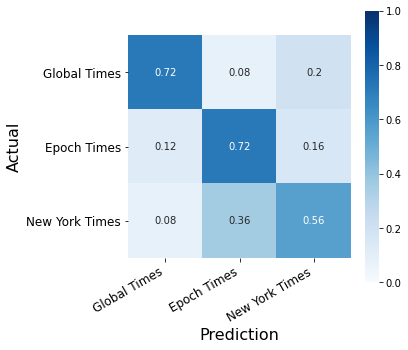

In [13]:
# Create a confusion matrix and plot, as before

cm = np.zeros((3, 3))

for i in range(len(x_2)):
    col = source_to_source_num[pred_2[i]]
    row = source_to_source_num[y_2[i]]
    cm[row][col] += 1

print(cm)

cm = cm/cm.sum(axis=1, keepdims=True)
cm = np.round(cm, 2)
print(cm)


fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(cm, annot=True, ax=ax, square=True,
            cmap=plt.cm.Blues, vmin=0, vmax=1,
            xticklabels=[source_num_to_source[num] for num in range(3)],
            yticklabels=[source_num_to_source[num] for num in range(3)]) 

ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, fontsize=12, ha='right')

ax.set_xlabel('Prediction', fontdict={'fontsize': 16})
ax.set_ylabel('Actual', fontdict={'fontsize': 16})

plt.show()

<h3>Part Three: Test Classifier on (Untuned) GPT-2 Outputs</h3>

In [14]:
# Preprocess GPT-2 articles in the same way as original articles were preprocessed

outputs['gpt2_cleaned'] = outputs['untuned_gpt2'].apply(lambda x: ' '.join(lemmatize(tokenize(regex(x)))))

outputs.head()

,title,gpt3,untuned_gpt2,ft_source_0,ft_source_1,ft_source_2,ft_source_3,ft_source_4,source,content,source_num,regexed,tokens,word_count,title_len,lemmas,joined,gpt3_cleaned,gpt2_cleaned
0,"Indian hawks, biased media, right-wing politic...",The Indian government should immediately withd...,15th anniversary of Mao Zedong? Xi Jinping wan...,"Photo: VCGWhile the talks are going smoothly, ...",The Chinese regime ’s persecution of Falun Gon...,BEIJING -- The spiritual leader of China's spi...,KOLKATA: The chairman of Karnataka Railways (K...,While the US and its allies have begun their f...,Global Times,Photo: Xinhua\n\n\n\n\nThe clash between China...,0.0,photo xinhua the clash between china and ...,"['photo', 'xinhua', 'clash', 'china', 'india',...",415.0,100.0,"['photo', 'xinhua', 'clash', 'china', 'india',...",photo xinhua clash china india galwan valley b...,indian government immediately withdraw troop c...,th anniversary mao zedong xi jinping want int...
1,Japanese firm's questions over Beijing court j...,"Besides the forced labor case, the Japanese fi...",China's Ministry of Labour said on Monday it w...,"Photo: VCGEmployees at a factory in Shenyang, ...",The Japanese government ’s Department of Justi...,BEIJING -- The Chinese authorities have punish...,BEIJING: The Chinese government is attacking a...,The ruling of the Permanent Court of Arbitrati...,Global Times,Chinese lawyers on Tuesday slammed a Japanese ...,0.0,chinese lawyers on tuesday slammed a japanese ...,"['chinese', 'lawyers', 'tuesday', 'slammed', '...",198.0,81.0,"['chinese', 'lawyer', 'tuesday', 'slammed', 'j...",chinese lawyer tuesday slammed japanese compan...,besides forced labor case japanese firm also s...,china ministry labour said monday close job ch...
2,Djibouti free trade zone demonstrates true val...,The second phase of the China-proposed Belt an...,China-supported Trade Partnership with Taiwan?...,"Photo: VCGChina-proposed B&R initiative, the C...",The World Trade Organization (WTO) announced a...,BEIJING -- The Chinese authorities have announ...,KOLKATA: The chairman of the five-member CUP (...,The latest US-China free-trade initiative had ...,Global Times,"Djibouti, capital of the East African state of...",0.0,djibouti capital of the east african state of...,"['djibouti', 'capital', 'east', 'african', 'st...",231.0,81.0,"['djibouti', 'capital', 'east', 'african', 'st...",djibouti capital east african state name getti...,second phase china proposed belt road initiati...,china supported trade partnership taiwan belie...
3,DPP victory would endanger cooperation to prot...,China is likely to claim victory in the Spratl...,China's Global Trade Policy Transparency Repor...,While the US and its allies have begun their e...,The Chinese regime ’s persecution of freedom o...,BEIJING -- The Chinese authorities have punish...,BEIJING: The Chinese delegation convened at a ...,The ruling Workers' Party (PPP) had accused th...,Global Times,"Recently, Taiwanese authorities have started a...",0.0,recently taiwanese authorities have started a...,"['recently', 'taiwanese', 'authorities', 'star...",410.0,77.0,"['recently', 'taiwanese', 'authority', 'starte...",recently taiwanese authority started adopting ...,china likely claim victory spratly island disp...,china global trade policy transparency report ...
4,China to require deletion of personal data 60 ...,China’s Ministry of Health has announced plans...,Labour's shadow health secretary said Britain ...,A station that processed data for Aadhaar driv...,"The Chinese regime is launching its ""Made in C...",HONG KONG -- The chairman of China's national ...,AHMEDABAD: The Department of Revenue had issue...,The World Health Organisation has said it is w...,Global Times,Data privacy Illustration: VCG\n\n\n\n\nThe St...,0.0,data privacy illustration vcg the state c...,"['data', 'privacy', 'illustration', 'vcg', 'st...",260.0,78.0,"['data', 'privacy', 'illustration', 'vcg', 'st...",data privacy illustration vcg state co

In [19]:
# Now vectorize the outputs and run them through the classifier

x_3 = outputs.gpt2_cleaned.tolist()
y_3 = outputs.source.tolist()

transformed_x_3 = vectorizer.transform(x_3)
    
pred_3 = naive.predict(transformed_x_3)
accuracy = accuracy_score(pred_3, y_3)*100
print("Naive Bayes Accuracy Score On GPT-2 Untuned Outputs -> ", accuracy)

Naive Bayes Accuracy Score On GPT-2 Untuned Outputs ->  50.66666666666667


[[11.  7.  7.]
 [ 5.  9. 11.]
 [ 1.  6. 18.]]
[[0.44 0.28 0.28]
 [0.2  0.36 0.44]
 [0.04 0.24 0.72]]


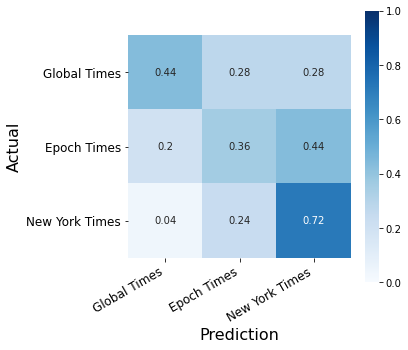

In [16]:
# Create a confusion matrix and plot, as before

cm = np.zeros((3, 3))

for i in range(len(x_3)):
    col = source_to_source_num[pred_3[i]]
    row = source_to_source_num[y_3[i]]
    cm[row][col] += 1

print(cm)

cm = cm/cm.sum(axis=1, keepdims=True)
cm = np.round(cm, 2)
print(cm)


fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(cm, annot=True, ax=ax, square=True,
            cmap=plt.cm.Blues, vmin=0, vmax=1,
            xticklabels=[source_num_to_source[num] for num in range(3)],
            yticklabels=[source_num_to_source[num] for num in range(3)]) 

ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, fontsize=12, ha='right')

ax.set_xlabel('Prediction', fontdict={'fontsize': 16})
ax.set_ylabel('Actual', fontdict={'fontsize': 16})

plt.show()

<h3>Part Four: Test Classifier on Finetuned Versions of GPT-2</h3>

In [17]:
# First select the appropriate output from the right model for each headline
# E.g. for an article from source 2, we care about the output from the ft_source_2 column

def select_finetuned_version(i):
    source_num = int(outputs['source_num'][i])
    column = "ft_source_{}".format(source_num)
    return outputs[column][i]

gpt2_tuned = [select_finetuned_version(i) for i in range(len(outputs))]

outputs['gpt2_tuned'] = gpt2_tuned
outputs.drop(columns=['ft_source_0', 'ft_source_1', 'ft_source_2', 'ft_source_3', 'ft_source_4'], inplace=True)

outputs.head()

,title,gpt3,untuned_gpt2,source,content,source_num,regexed,tokens,word_count,title_len,lemmas,joined,gpt3_cleaned,gpt2_cleaned,gpt2_tuned
0,"Indian hawks, biased media, right-wing politic...",The Indian government should immediately withd...,15th anniversary of Mao Zedong? Xi Jinping wan...,Global Times,Photo: Xinhua\n\n\n\n\nThe clash between China...,0.0,photo xinhua the clash between china and ...,"['photo', 'xinhua', 'clash', 'china', 'india',...",415.0,100.0,"['photo', 'xinhua', 'clash', 'china', 'india',...",photo xinhua clash china india galwan valley b...,indian government immediately withdraw troop c...,th anniversary mao zedong xi jinping want int...,"Photo: VCGWhile the talks are going smoothly, ..."
1,Japanese firm's questions over Beijing court j...,"Besides the forced labor case, the Japanese fi...",China's Ministry of Labour said on Monday it w...,Global Times,Chinese lawyers on Tuesday slammed a Japanese ...,0.0,chinese lawyers on tuesday slammed a japanese ...,"['chinese', 'lawyers', 'tuesday', 'slammed', '...",198.0,81.0,"['chinese', 'lawyer', 'tuesday', 'slammed', 'j...",chinese lawyer tuesday slammed japanese compan...,besides forced labor case japanese firm also s...,china ministry labour said monday close job ch...,"Photo: VCGEmployees at a factory in Shenyang, ..."
2,Djibouti free trade zone demonstrates true val...,The second phase of the China-proposed Belt an...,China-supported Trade Partnership with Taiwan?...,Global Times,"Djibouti, capital of the East African state of...",0.0,djibouti capital of the east african state of...,"['djibouti', 'capital', 'east', 'african', 'st...",231.0,81.0,"['djibouti', 'capital', 'east', 'african', 'st...",djibouti capital east african state name getti...,second phase china proposed belt road initiati...,china supported trade partnership taiwan belie...,"Photo: VCGChina-proposed B&R initiative, the C..."
3,DPP victory would endanger cooperation to prot...,China is likely to claim victory in the Spratl...,China's Global Trade Policy Transparency Repor...,Global Times,"Recently, Taiwanese authorities have started a...",0.0,recently taiwanese authorities have started a...,"['recently', 'taiwanese', 'authorities', 'star...",410.0,77.0,"['recently', 'taiwanese', 'authority', 'starte...",recently taiwanese authority started adopting ...,china likely claim victory spratly island disp...,china global trade policy transparency report ...,While the US and its allies have begun their e...
4,China to require deletion of personal data 60 ...,China’s Ministry of Health has announced plans...,Labour's shadow health secretary said Britain ...,Global Times,Data privacy Illustration: VCG\n\n\n\n\nThe St...,0.0,data privacy illustration vcg the state c...,"['data', 'privacy', 'illustration', 'vcg', 'st...",260.0,78.0,"['data', 'privacy', 'illustration', 'vcg', 'st...",data privacy illustration vcg state council ch...,china ministry health announced plan revise co...,labour shadow health secretary said britain si...,A station that processed data for Aadhaar driv...


In [18]:
# Preprocess fine-tuned GPT-2 articles in the same way as original articles were preprocessed

outputs['gpt2_tuned_cleaned'] = outputs['gpt2_tuned'].apply(lambda x: ' '.join(lemmatize(tokenize(regex(x)))))

outputs.head()

,title,gpt3,untuned_gpt2,source,content,source_num,regexed,tokens,word_count,title_len,lemmas,joined,gpt3_cleaned,gpt2_cleaned,gpt2_tuned,gpt2_tuned_cleaned
0,"Indian hawks, biased media, right-wing politic...",The Indian government should immediately withd...,15th anniversary of Mao Zedong? Xi Jinping wan...,Global Times,Photo: Xinhua\n\n\n\n\nThe clash between China...,0.0,photo xinhua the clash between china and ...,"['photo', 'xinhua', 'clash', 'china', 'india',...",415.0,100.0,"['photo', 'xinhua', 'clash', 'china', 'india',...",photo xinhua clash china india galwan valley b...,indian government immediately withdraw troop c...,th anniversary mao zedong xi jinping want int...,"Photo: VCGWhile the talks are going smoothly, ...",photo vcgwhile talk going smoothly critic call...
1,Japanese firm's questions over Beijing court j...,"Besides the forced labor case, the Japanese fi...",China's Ministry of Labour said on Monday it w...,Global Times,Chinese lawyers on Tuesday slammed a Japanese ...,0.0,chinese lawyers on tuesday slammed a japanese ...,"['chinese', 'lawyers', 'tuesday', 'slammed', '...",198.0,81.0,"['chinese', 'lawyer', 'tuesday', 'slammed', 'j...",chinese lawyer tuesday slammed japanese compan...,besides forced labor case japanese firm also s...,china ministry labour said monday close job ch...,"Photo: VCGEmployees at a factory in Shenyang, ...",photo vcgemployees factory shenyang east china...
2,Djibouti free trade zone demonstrates true val...,The second phase of the China-proposed Belt an...,China-supported Trade Partnership with Taiwan?...,Global Times,"Djibouti, capital of the East African state of...",0.0,djibouti capital of the east african state of...,"['djibouti', 'capital', 'east', 'african', 'st...",231.0,81.0,"['djibouti', 'capital', 'east', 'african', 'st...",djibouti capital east african state name getti...,second phase china proposed belt road initiati...,china supported trade partnership taiwan belie...,"Photo: VCGChina-proposed B&R initiative, the C...",photo vcgchina proposed b r initiative china p...
3,DPP victory would endanger cooperation to prot...,China is likely to claim victory in the Spratl...,China's Global Trade Policy Transparency Repor...,Global Times,"Recently, Taiwanese authorities have started a...",0.0,recently taiwanese authorities have started a...,"['recently', 'taiwanese', 'authorities', 'star...",410.0,77.0,"['recently', 'taiwanese', 'authority', 'starte...",recently taiwanese authority started adopting ...,china likely claim victory spratly island disp...,china global trade policy transparency report ...,While the US and its allies have begun their e...,u ally begun effort attack china u ruled using...
4,China to require deletion of personal data 60 ...,China’s Ministry of Health has announced plans...,Labour's shadow health secretary said Britain ...,Global Times,Data privacy Illustration: VCG\n\n\n\n\nThe St...,0.0,data privacy illustration vcg the state c...,"['data', 'privacy', 'illustration', 'vcg', 'st...",260.0,78.0,"['data', 'privacy', 'illustration', 'vcg', 'st...",data privacy illustration vcg state council ch...,china ministry health announced plan revise co...,labour shadow health secretary said britain si...,A station that processed data for Aadhaar driv...,station processed data aadhaar drive storage u...


In [20]:
# Now vectorize the outputs and run them through the classifier

x_4 = outputs.gpt2_tuned_cleaned.tolist()
y_4 = outputs.source.tolist()

transformed_x_4 = vectorizer.transform(x_4)
    
pred_4 = naive.predict(transformed_x_4)
accuracy = accuracy_score(pred_4, y_4)*100
print("Naive Bayes Accuracy Score On GPT-2 Finetuned Outputs -> ", accuracy)

Naive Bayes Accuracy Score On GPT-2 Finetuned Outputs ->  97.33333333333334


[[25.  0.  0.]
 [ 0. 25.  0.]
 [ 0.  2. 23.]]
[[1.   0.   0.  ]
 [0.   1.   0.  ]
 [0.   0.08 0.92]]


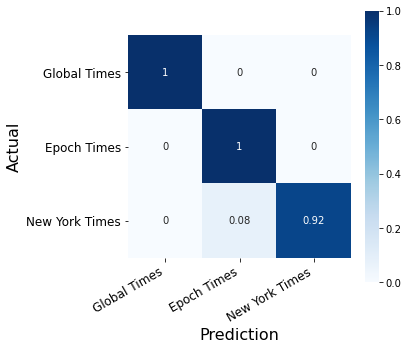

In [21]:
# Create a confusion matrix and plot, as before

cm = np.zeros((3, 3))

for i in range(len(x_4)):
    col = source_to_source_num[pred_4[i]]
    row = source_to_source_num[y_4[i]]
    cm[row][col] += 1

print(cm)

cm = cm/cm.sum(axis=1, keepdims=True)
cm = np.round(cm, 2)
print(cm)


fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(cm, annot=True, ax=ax, square=True,
            cmap=plt.cm.Blues, vmin=0, vmax=1,
            xticklabels=[source_num_to_source[num] for num in range(3)],
            yticklabels=[source_num_to_source[num] for num in range(3)]) 

ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, fontsize=12, ha='right')

ax.set_xlabel('Prediction', fontdict={'fontsize': 16})
ax.set_ylabel('Actual', fontdict={'fontsize': 16})

plt.show()